In [1]:
# DICE SM - Exploration & Global Sensitivity Analysis
# Shridhar
#  saved 1428

  ## Setup & Initialisation of levers and uncertainties

In [309]:
import time

import matplotlib.pyplot as plt
from ema_workbench import (Model, RealParameter, IntegerParameter, ArrayOutcome, TimeSeriesOutcome,
                           ema_logging, SequentialEvaluator,
                           MultiprocessingEvaluator)
from ema_workbench import save_results, load_results
from ema_workbench.analysis import prim
from ema_workbench.analysis import scenario_discovery_util as sdutil
from sklearn import preprocessing 
import numpy as np
ema_logging.log_to_stderr(ema_logging.INFO)
# from ema_workbench.analysis import pairs_plotting
# from PyDICE_V4_array_outcome import PyDICE
from dicemodel.MyDICE_v4 import PyDICE


In [310]:

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                             IntegerParameter('t2xco2_dist',0,2),

                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600)]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('prtp_dam',  0.001, 0.015),
                      RealParameter('emuc',  0.5, 1.5),
                      RealParameter('emdd',  0.5, 1.5),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)]
    
    dice_sm.outcomes = [TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Damages'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Savings rate'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Damage to output ratio'),
                        TimeSeriesOutcome('Welfare'),
                        TimeSeriesOutcome('Total Output')]
    
    
    n_scenarios = 100
    n_policies = 10


In [311]:
    start = time.time()
    with MultiprocessingEvaluator(dice_sm, n_processes=8) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios,policies=n_policies)
    end = time.time()
    
    print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 10 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Experiment time is 5 mintues


In [322]:
save_results(results, 'openexp_r_100s_10p.tar.gz')

[MainProcess/INFO] results saved successfully to e:\Year_2_Quarter_4\Thesis\06_Code\noDICE\openexp_r_100s_10p.tar.gz


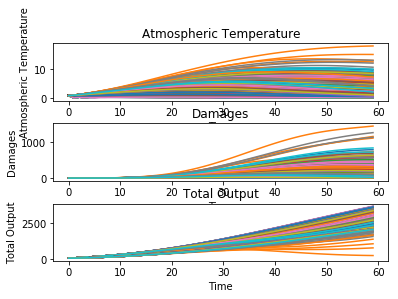

In [315]:
## Lines plotting
# How to make it bigger?

import matplotlib.pyplot as plt
from ema_workbench.analysis.plotting import lines

figure = lines(experiments, outcomes, outcomes_to_show = ['Atmospheric Temperature', 'Damages', 'Total Output']) #show lines, and end state density
fig.set_size_inches(10000,10) #doesn't seem to change anything
plt.show() #show figure

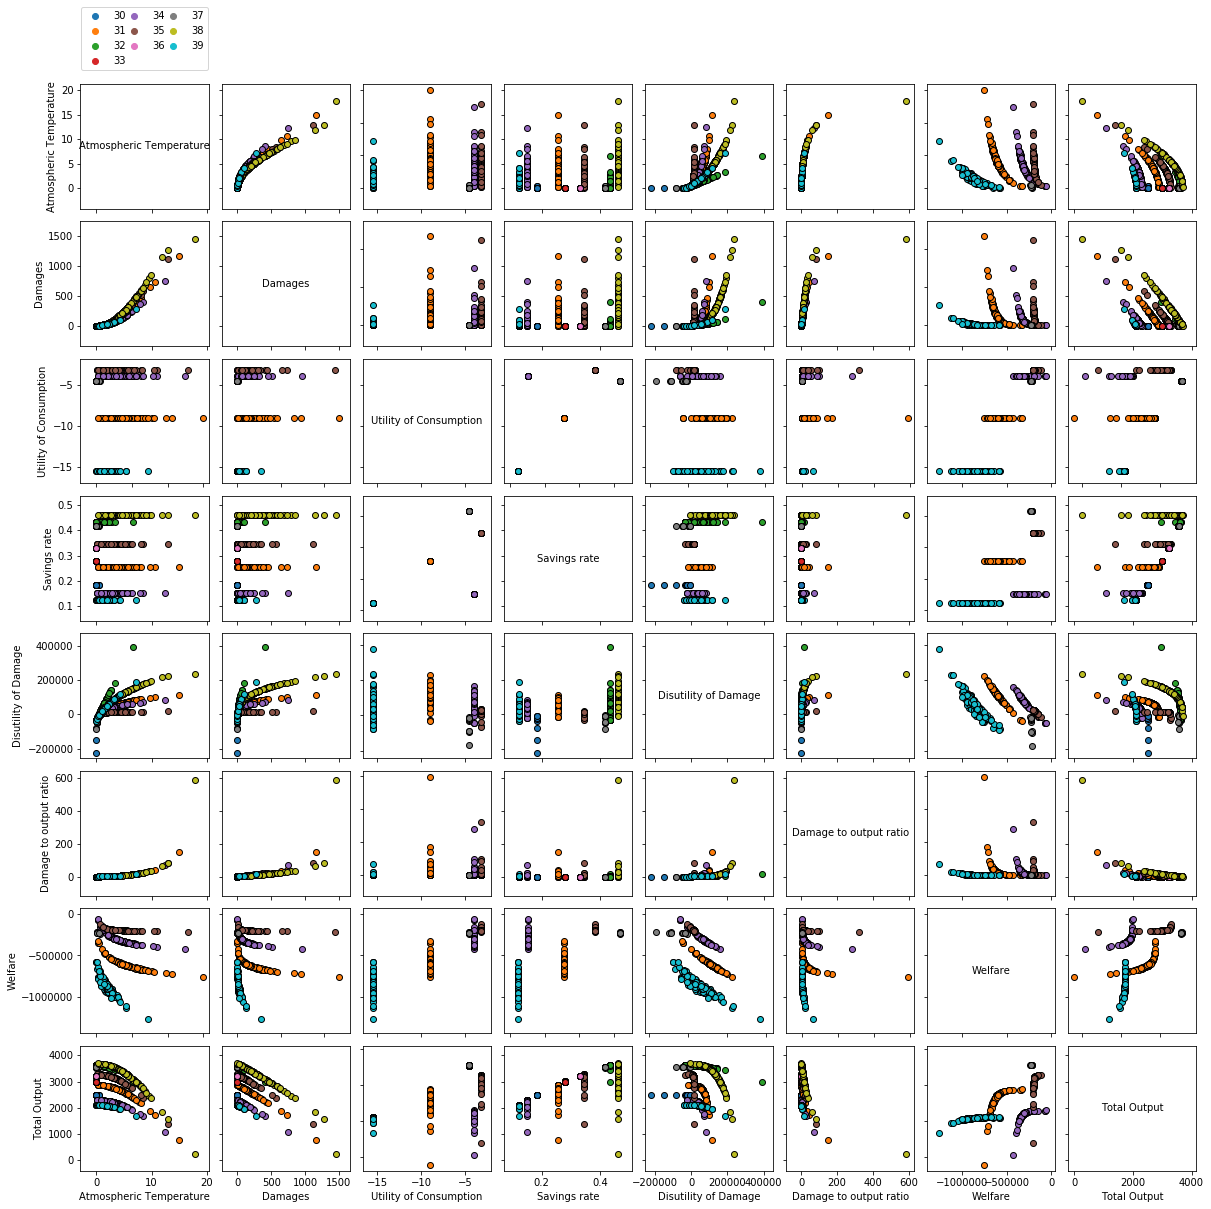

In [313]:
## pairs plotting
from ema_workbench.analysis import pairs_plotting
fig, axes = pairs_plotting.pairs_scatter(experiments,outcomes, group_by='policy',legend=True)
fig.set_size_inches(20,20)
plt.show()

In [316]:
outcomes

{'Atmospheric Temperature': array([[0.8       , 0.95696708, 1.1212136 , ..., 0.        , 0.        ,
         0.        ],
        [0.8       , 0.95138498, 1.10999588, ..., 0.        , 0.        ,
         0.        ],
        [0.8       , 0.94262225, 1.09140995, ..., 0.30405728, 0.24604285,
         0.18984219],
        ...,
        [0.8       , 0.98781501, 1.18665353, ..., 4.47264832, 4.35069752,
         4.2289266 ],
        [0.8       , 0.91869382, 1.0422102 , ..., 1.20111721, 1.14019232,
         1.08085125],
        [0.8       , 0.96930217, 1.14712302, ..., 2.33374021, 2.17902778,
         2.02425868]]),
 'Damages': array([[  0.1086489 ,   0.17610722,   0.27563479, ...,   0.        ,
           0.        ,   0.        ],
        [  0.1086489 ,   0.17463258,   0.27182635, ...,   0.        ,
           0.        ,   0.        ],
        [  0.1086489 ,   0.17187642,   0.26407887, ...,   0.59312847,
           0.39676735,   0.24115458],
        ...,
        [  0.1086489 ,   0.1794584

In [317]:
## PRIM
# set x, y args + clean experiments + perform prim for diff outcomes + analyze (ref ...uncertaintystuff.ipynb)
# perform dimensional stacking
# x = experiments
# outcomes is nd-array, PRIM needs 1D
# y = outcomes['Atmospheric Temperature']
# y = np.amax(outcomes['Atmospheric Temperature'], axis =1) 
# y = np.amax(outcomes)
# y = np.amax(outcomes, axis =0)
y = outcomes

## verify
y['Atmospheric Temperature'].shape 

(1000, 60)

In [318]:
## Binary classification of results

data_temp = np.amax(y['Atmospheric Temperature'], axis =1) 
y_temp = data_temp < 4.0

# adjust percentile
data_damage = np.amax(y['Damages'], axis =1)
y_damage = data_damage < np.percentile(data_damage, 20)

data_utility_con = np.amax(y['Utility of Consumption'], axis =1)
y_utility_con = data_utility_con < np.percentile(data_utility_con, 20)

# data_sr = outcomes['Savings Rate']
# y_sr = data_sr < np.percentile(data_sr, 20)

data_disutil_dam = np.amax(y['Disutility of Damage'], axis =1)
y_disutil_dam = data_disutil_dam < np.percentile(data_disutil_dam, 20)

data_dam_ratio = np.amax(y['Damage to output ratio'], axis =1)
y_dam_ratio = data_dam_ratio < np.percentile(data_dam_ratio, 20)

data_welfare = np.amax(y['Welfare'], axis =1)
y_welfare = data_welfare < np.percentile(data_welfare, 20)

data_output = np.amax(y['Total Output'], axis = 1)
y_output = data_output < np.percentile(data_output, 20)

## verify
# y_damage.shape 
y_temp 

C:\Users\shrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False,

In [319]:
cleaned_experiments = experiments.drop(labels=[l.name for l in dice_sm.uncertainties], axis=1)

In [320]:
# change the y_... name to the name that will give you the outcome you want to analyse as defined above

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.


prim_alg = prim.Prim(cleaned_experiments, y_temp, threshold=0.8, peel_alpha=0.1 ) #0.1 

[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] 1000 points remaining, containing 574 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1, coverage: 0.17421602787456447, density: 1.0 restricted_dimensions: 3


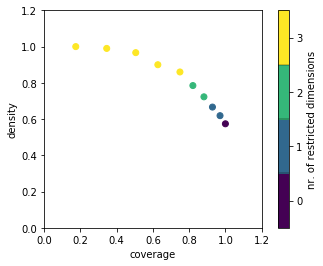

In [321]:
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

In [323]:
box1.inspect()
plt.show()


coverage    0.174216
density            1
id                 9
mass             0.1
mean               1
res_dim            3
Name: 9, dtype: object

                box 9             \
                  min        max   
miu_period  10.000000  49.000000   
emdd         1.156663   1.323565   
emuc         0.693844   1.408555   

                                                            
                                                 qp values  
miu_period                                     [-1.0, 1.0]  
emdd        [6.163803848904473e-12, 8.747673630108587e-08]  
emuc                            [1.0, 0.01687031935884957]  



In [303]:
# testing arguments for df to debug

df_index = np.arange(1000)
df_index.shape
max_outcomes = np.amax(outcomes)
max_outcomes

{'Atmospheric Temperature': array([[0.8       , 0.95696708, 1.1212136 , ..., 0.        , 0.        ,
         0.        ],
        [0.8       , 0.95138498, 1.10999588, ..., 0.        , 0.        ,
         0.        ],
        [0.8       , 0.94262225, 1.09140995, ..., 0.30405728, 0.24604285,
         0.18984219],
        ...,
        [0.8       , 0.98781501, 1.18665353, ..., 4.47264832, 4.35069752,
         4.2289266 ],
        [0.8       , 0.91869382, 1.0422102 , ..., 1.20111721, 1.14019232,
         1.08085125],
        [0.8       , 0.96930217, 1.14712302, ..., 2.33374021, 2.17902778,
         2.02425868]]),
 'Damages': array([[  0.1086489 ,   0.17610722,   0.27563479, ...,   0.        ,
           0.        ,   0.        ],
        [  0.1086489 ,   0.17463258,   0.27182635, ...,   0.        ,
           0.        ,   0.        ],
        [  0.1086489 ,   0.17187642,   0.26407887, ...,   0.59312847,
           0.39676735,   0.24115458],
        ...,
        [  0.1086489 ,   0.1794584

In [ ]:
box1.select(21)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
############################################

In [304]:
## put results in excel
import pandas as pd

outcomes_df = pd.DataFrame(max_outcomes, index = df_index)
experiments_df = pd.DataFrame(experiments)
df_results = pd.concat([outcomes_df, experiments_df], axis=1)
df_results.to_excel("r_100s_10p.xlsx")

Exception: Data must be 1-dimensional

In [262]:
# data_temp = outcomes['Atmospheric Temperature']
# y_temp = data_temp < 4.0

# # adjust percentile
# data_damage = outcomes['Damages']
# y_damage = data_damage < np.percentile(data_damage, 20)

# data_utility_con = outcomes['Utility of Consumption']
# y_utility_con = data_utility_con < np.percentile(data_utility_con, 20)

# # data_sr = outcomes['Savings Rate']
# # y_sr = data_sr < np.percentile(data_sr, 20)

# data_disutil_dam = outcomes['Disutility of Damage']
# y_disutil_dam = data_disutil_dam < np.percentile(data_disutil_dam, 20)

# data_dam_ratio = outcomes['Damage to output ratio']
# y_dam_ratio = data_dam_ratio < np.percentile(data_dam_ratio, 20)

# data_welfare = outcomes['Welfare']
# y_welfare = data_welfare < np.percentile(data_welfare, 20)

# data_output = outcomes['Total Output']
# y_output = data_output < np.percentile(data_output, 20)

# # y = np.amax(outcomes['Atmospheric Temperature'], axis =1) 
# y_temp

C:\Users\shrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [169]:
results_prim = experiments, outcomes
results_prim

# classify_prim = 'Atmospheric Temperature'
# classify_prim = y
# classify_prim = np.amax(outcomes['Atmospheric Temperature'], axis =1) 
# classify_prim = outcomes['Atmospheric Temperature']
classify_prim = 'y_dict'
classify_prim

prim_setup = prim.setup_prim(results = results_prim, classify = classify_prim, threshold = 0.8)
prim_setup = prim.setup_prim(x, classify = classify_prim, threshold = 0.8,**kwargs)


KeyError: 'y_dict'

In [158]:
''' 
########################## adapted from EMA workbench Mexican Flu example #################################
Converting the outcome into a dictionary when PRIM returns a TypeError due to unhashable dictionary
prim.prim requires y to be a 1D array, so why are we doing this?

Is there some other way we can use the flu example for scenario discovery?
In the flu example, there is a zero policy already decided through vensim, but here we are trying to find 
the most vulnerable scenarios across a large ensemble of policies through PRIM.
i.e. we use PRIM to get uncertainty + policy subspace which gives undesirable outcomes 
'''
# transform the outcomes to the required format 

y_dict = {}


# get time and remove it from the dict
for key, value in outcomes.items():
    if key == 'Atmospheric Temperature':
        max_temp = np.max(value, axis=1)
        y_dict['max temp'] = max_temp
    else:
        y_dict[key] = value[:, -1]
y_dict



# commenting out because we don't have a time index
        # we want the time at which the maximum occurred
        # the code here is a bit obscure, I don't know why the transpose
        # of value is needed. This however does produce the appropriate results
#         logical = value.T == np.max(value, axis=1)
#         tr['time of max'] = time[logical.T]

{'max temp': array([ 3.52740167,  3.49102016,  3.09540374,  3.88879132,  2.09686166,
         2.75059787,  2.8422063 ,  3.7333176 ,  2.89057716,  1.03768638,
         3.5212701 ,  2.73472835,  3.02819471,  3.1601232 ,  1.06524023,
         3.58920225,  3.2081409 ,  3.04260852,  1.46615717,  0.8       ,
         2.96117971,  3.07017643,  3.05533256,  1.87659858,  3.42166379,
         3.14659872,  2.67206873,  2.49472486,  2.05128866,  2.12669329,
         2.77091445,  2.77672981,  0.8       ,  1.46858015,  3.18514196,
         3.39349654,  3.45277813,  2.47762096,  3.04793052,  2.74470468,
         2.21141148,  2.30542625,  3.42875484,  2.91719588,  3.53709341,
         2.44433171,  2.39847241,  1.96517108,  3.56535112,  2.25514931,
         1.01981562,  6.36771501,  1.04552567,  3.91253977,  1.68820582,
         2.58665676,  3.46220419,  2.52523966,  2.24149785,  3.67977114,
         4.3185884 ,  2.8181735 ,  3.75032124,  2.83703064,  2.93277493,
         1.88999101,  3.2013188 ,  1.67